In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

## General configuration

In [3]:
import torch

In [4]:
# Print some information on the GPU
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
2
Tesla K20c


/home/ispamm/anaconda3/lib/python3.6/site-packages/torch/cuda/__init__.py:117: UserWarning: 
    Found GPU1 Quadro K4000 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [127]:
# Load parameters
import configs.config_mnist as config

import importlib
importlib.reload(config)

config = config.config
chosen_importance = config['ewc']['importance']

In [128]:
config

{'ewc': {'importance': 1000, 'sample_size': 250},
 'opt': {'batch_size': 64,
  'epochs': 10,
  'iters': 1,
  'l1_reg': 0.0001,
  'lr': 0.001},
 'other': {'device': device(type='cuda'),
  'enable_tensorboard': True,
  'model_name': '',
  'run_name': 'mnist'},
 'task': {'is_conv': False, 'num_tasks': 3}}

## Load data

In [97]:
# Load num_tasks datasets

from data import CustomDataLoader, PermutedMNIST
from tqdm import tqdm_notebook as tqdm
import random

train_loader = {}
test_loader = {}

idx = list(range(28 * 28))

for i in tqdm(range(config['task']['num_tasks']), 'Datasets loaded'):
  train_loader[i] = CustomDataLoader(PermutedMNIST(train=True, permute_idx=idx),
                                                      batch_size=config['opt']['batch_size'])
  test_loader[i] = CustomDataLoader(PermutedMNIST(train=False, permute_idx=idx),
                                                     batch_size=config['opt']['batch_size'])
  random.shuffle(idx)

## Define models

In [99]:
hidden_size = 250

In [100]:
from torch import nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, hidden_size=400):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 10)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
      
    def set_task(self, t):
      self.current_task = t

In [101]:
from models import KAF, elu

class KAFMLP(nn.Module):
    def __init__(self, hidden_size=400, kaf_init_fcn=elu):
        super(KAFMLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 10)
        self.kaf1 = KAF(hidden_size, init_fcn=kaf_init_fcn, D=20)
        self.kaf2 = KAF(hidden_size, init_fcn=kaf_init_fcn, D=20)
        self.kaf3 = KAF(hidden_size, init_fcn=kaf_init_fcn, D=20)

    def forward(self, input):
        x = self.kaf1(self.fc1(input))
        x = self.kaf2(self.fc2(x))
        x = self.kaf3(self.fc3(x))
        x = self.fc4(x)
        return x
      
    def set_task(self, t):
      self.current_task = t

In [129]:
net = MLP(hidden_size).to(config['other']['device'])

In [130]:
kafnet = KAFMLP(int(hidden_size * 0.70)).to(config['other']['device'])

In [131]:
print('Numero di parametri rete classica: ', sum([torch.numel(p) for p in net.parameters()]))
print('Numero di parametri KAFNET: ', sum([torch.numel(p) for p in kafnet.parameters()]))

Numero di parametri rete classica:  324260
Numero di parametri KAFNET:  211235


## Main experiment

In [132]:
torch.save(net.state_dict(), 'models/net.pt')
torch.save(kafnet.state_dict(), 'models/kafnet.pt')

In [133]:
print('Training standard network with no penalty')
from train import repeat_train_n_times
config['ewc']['importance'] = 0.0 # Temporarily disable importance
config['other']['model_name'] = 'NN' # Select a name for the model saving
loss, loss_full, acc = repeat_train_n_times(net, train_loader, test_loader, 
                                            net_init_path='models/net.pt', 
                                            config=config)

Training standard network with no penalty


*** ITER  1  of  1  ***


Training for task 1 of 3...



Training for task 2 of 3...


Training for task 3 of 3...


In [134]:
print('Training standard network with EWC penalty')
config['ewc']['importance'] = chosen_importance # Re-enable importance
config['other']['model_name'] = 'EWC-NN' # Select a name for the model saving
loss_ewc, loss_full_ewc, acc_ewc = repeat_train_n_times(net, train_loader, test_loader,\
                                            net_init_path='models/net.pt', 
                                            config=config)

Training standard network with EWC penalty


*** ITER  1  of  1  ***


Training for task 1 of 3...


Training for task 2 of 3...


Training for task 3 of 3...


In [135]:
print('Training KAF network with no penalty')
config['ewc']['importance'] = 0.0 # Temporarily disable importance
config['other']['model_name'] = 'KAF' # Select a name for the model saving
loss_kaf, loss_full_kaf, acc_kaf = repeat_train_n_times(kafnet, train_loader, test_loader, \
                                            net_init_path='models/kafnet.pt', 
                                            config=config)

Training KAF network with no penalty


*** ITER  1  of  1  ***


Training for task 1 of 3...


Training for task 2 of 3...


Training for task 3 of 3...


In [ ]:
print('Training KAF network with EWC penalty')
config['ewc']['importance'] = chosen_importance # Re-enable importance
config['other']['model_name'] = 'EWC-KAF' # Select a name for the model saving
loss_kaf_ewc, loss_full_kaf_ewc, acc_kaf_ewc = repeat_train_n_times(kafnet, train_loader, test_loader,
                                            net_init_path='models/kafnet.pt', 
                                            config=config)

Training KAF network with EWC penalty


*** ITER  1  of  1  ***


Training for task 1 of 3...


Training for task 2 of 3...


Training for task 3 of 3...


## Some plots

In [137]:
%matplotlib inline

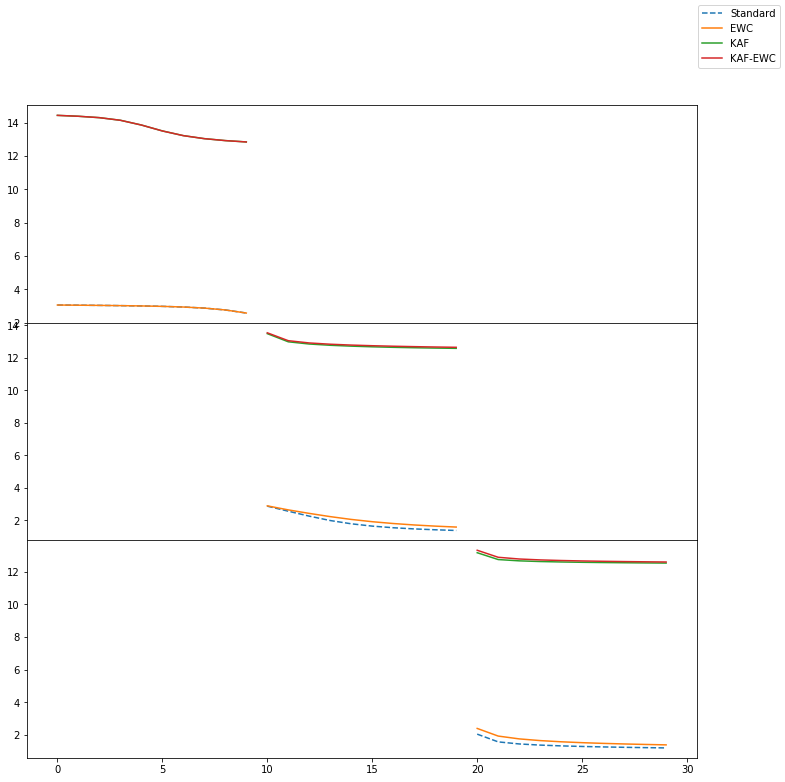

In [138]:
import matplotlib.pyplot as plt

num_tasks = config['task']['num_tasks']
epochs = config['opt']['epochs']

# Loss plots
f, ax = plt.subplots(config['task']['num_tasks'], 1, sharex=True, figsize=(12, 12))

# Plot loss for standard network / standard training
for t, v in loss.items():
  ax[t].plot(list(range(t * epochs, (t + 1) * epochs)), v, '--', label='Standard')

# Plot loss for standard network / EWC training
for t, v in loss_ewc.items():
  ax[t].plot(list(range(t * epochs, (t + 1) * epochs)), v, label='EWC')
  
# Plot loss for KAF network / standard training
for t, v in loss_kaf.items():
  ax[t].plot(list(range(t * epochs, (t + 1) * epochs)), v, label='KAF')
  
# Plot loss for KAF network / EWC training
for t, v in loss_kaf_ewc.items():
  ax[t].plot(list(range(t * epochs, (t + 1) * epochs)), v, label='KAF-EWC')
  

# Add legend
handles, labels = ax[-1].get_legend_handles_labels()
f.legend(handles, labels, loc='upper right')

f.subplots_adjust(hspace=0)
plt.show()

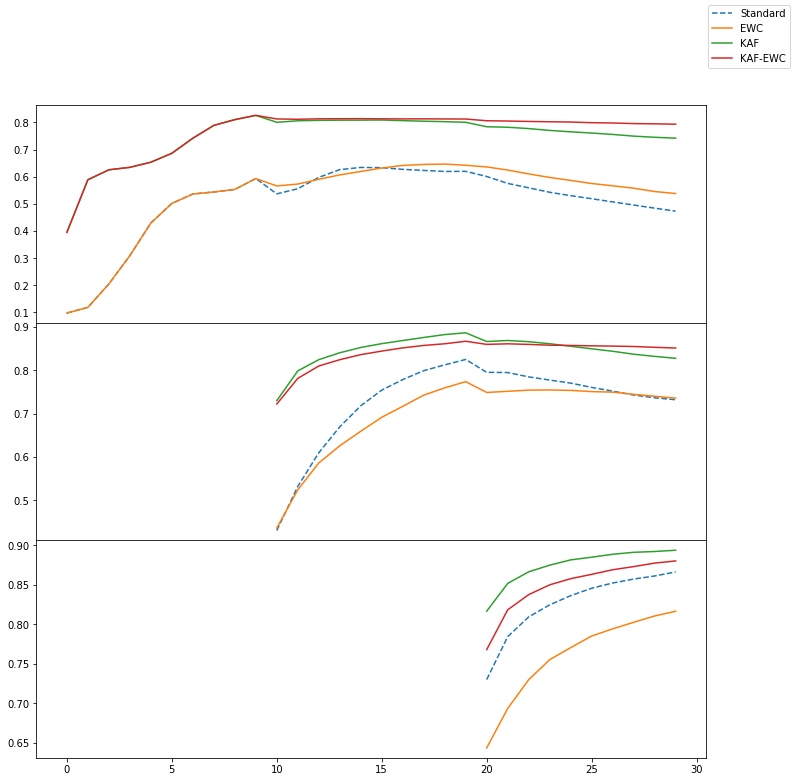

In [139]:
# Accuracy plots
f, ax = plt.subplots(num_tasks, 1, sharex=True, figsize=(12, 12))

# Plot accuracy for standard network / standard training
for t, v in acc.items():
  x_axis = list(range(t * epochs, num_tasks * epochs))
  ax[t].plot(x_axis, v, '--', label='Standard')
  
# Plot accuracy for standard network / EWC training
for t, v in acc_ewc.items():
  x_axis = list(range(t * epochs, num_tasks * epochs))
  ax[t].plot(x_axis, v, label='EWC')
  
# Plot accuracy for KAF network / standard training
for t, v in acc_kaf.items():
  x_axis = list(range(t * epochs, num_tasks * epochs))
  ax[t].plot(x_axis, v, label='KAF')
  
# Plot accuracy for KAF network / EWC training
for t, v in acc_kaf_ewc.items():
  x_axis = list(range(t * epochs, num_tasks * epochs))
  ax[t].plot(x_axis, v, label='KAF-EWC')
  
 
# Add legend
handles, labels = ax[-1].get_legend_handles_labels()
f.legend(handles, labels, loc='upper right')

f.subplots_adjust(hspace=0)
plt.show()